# DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves

By Muhammad Ruhaib, BE22B005

In [3]:
!pip install ucimlrepo
!pip install xgboost

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Part A: Data Preparation and Baseline

## A.1: Load and Prepare Data

I've fetched the dataset directly from the UCI repository using the `ucimlrepo` library.  

In [5]:
#Taken from https://archive.ics.uci.edu/dataset/146/statlog+landsat+satellite
from ucimlrepo import fetch_ucirepo

statlog_landsat_satellite = fetch_ucirepo(id=146)
X = statlog_landsat_satellite.data.features
y = statlog_landsat_satellite.data.targets

print('Metadata:')
print(statlog_landsat_satellite.metadata)
print('\nVariables/feature info:')
print(statlog_landsat_satellite.variables)

print('\nX shape:', X.shape)
print('y shape:', y.shape)

Metadata:
{'uci_id': 146, 'name': 'Statlog (Landsat Satellite)', 'repository_url': 'https://archive.ics.uci.edu/dataset/146/statlog+landsat+satellite', 'data_url': 'https://archive.ics.uci.edu/static/public/146/data.csv', 'abstract': 'Multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood', 'area': 'Climate and Environment', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6435, 'num_features': 36, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C55887', 'creators': ['Ashwin Srinivasan'], 'intro_paper': None, 'additional_info': {'summary': "The database consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classif

The dataset has a total of 6435 datapoints, each with 36 features.

In [6]:
unique_labels = np.unique(y)
print('Unique labels:', unique_labels)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Encoded classes mapping:')
for i, c in enumerate(le.classes_):
    print(i, c)

Unique labels: [1 2 3 4 5 7]
Encoded classes mapping:
0 1
1 2
2 3
3 4
4 5
5 7


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


While there are supposed to be 7 labels, we see that the count on unique labels doesn't include label 6 - which according to the dataset's website, corresponds to the mixture class. For convenience in our model building and prediction, I've renumbered the 6 existing classes accordingly.

## A.2: Train/Test split

Now, I've split the data into **training (70%)** and **testing (30%)** subsets.  
Stratified sampling is used to maintain class distribution in both sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=42, stratify=y_enc)
print('Train/test sizes:', X_train.shape, X_test.shape)

Train/test sizes: (4504, 36) (1931, 36)


Since we're using models like SVM, Logistic Regression, and KNN which are sensitive to feature scaling, I've applied standardization for all the input features.

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## A.3, 4: Train and evaluate all models

In [9]:
models = {
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'Dummy_Prior': DummyClassifier(strategy='prior', random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear'),
    'GaussianNB': GaussianNB(),
    'SVC': SVC(probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42), #Brownie points models :)
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

Each model is trained on the training set and evaluated on the test set.  
The two metrics used are:

- Accuracy: Measures the proportion of correct predictions overall.
- Weighted F1-score: Balances precision and recall while considering class imbalance.

In [10]:
results = []
trained_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1_w = f1_score(y_test, y_pred, average='weighted')
    results.append({'model': name, 'accuracy': acc, 'weighted_f1': f1_w})

results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False).reset_index(drop=True)
results_df

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:52:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,model,accuracy,weighted_f1
0,XGBoost,0.917141,0.915578
1,RandomForest,0.916624,0.913761
2,KNN,0.912481,0.911477
3,SVC,0.897462,0.895996
4,LogisticRegression,0.836872,0.810358
5,DecisionTree,0.836354,0.837073
6,GaussianNB,0.793371,0.800111
7,Dummy_Prior,0.238219,0.091661


We see a clear separation between strong and weak classifiers. The top performers are XGBoost, RandomForest, and KNN, each achieving around 91–92% accuracy with nearly identical weighted F1-scores, indicating that these models not only make accurate predictions overall but also maintain a good balance between precision and recall across all classes. Ensemble methods such as XGBoost and RandomForest combine multiple decision trees, capturing complex nonlinear relationships and reducing variance, which explains their consistently high performance. KNN also performs well due to its non-parametric nature and ability to adapt to local decision boundaries in the feature space.

Slightly below this top tier are SVC, Logistic Regression, and Decision Tree. SVC achieves an accuracy of about 89.7%, showing that it is a strong linear-margin classifier when properly scaled, though it may be less flexible for certain nonlinear boundaries. Logistic Regression and Decision Tree models, both at around 83–84% accuracy, perform moderately well but lag behind the ensemble and instance-based methods. Logistic Regression’s linear decision boundaries are likely too simple for this complex feature space, while a single Decision Tree could overfit specific training patterns.

Towards the lower end, Guassian Naive Bayes scores 79%. I believe this is because its assumption of feature independence does not align well with the highly correlated spectral features of the Landsat dataset. Finally, the Dummy classifier achieves only about 24% accuracy and a very low weighted F1 of 0.09, as expected for a model that predicts purely according to class frequencies.

# Part B: ROC Analysis for Model Selection

## B.1: Multi-Class ROC Calculation

While accuracy gives a single-number summary, it hides how models handle class imbalance and decision thresholds.

The Receiver Operating Characteristic (ROC) curve helps visualize this tradeoff by plotting True Positive Rate (TPR) vs. False Positive Rate (FPR) at various thresholds.

For multi-class problems, we use the One-vs-Rest (OvR) approach to compute individual ROC curves for each class and then average them.

In OvR, for each class, the model treats that class as “positive” and all others as “negative.”  
This way, we can compute an ROC curve per class and then average them to obtain a macro-averaged ROC curve.

- Macro-average: Treats all classes equally.
- Micro-average: Weights classes by their frequency.

In this assignment, I've used the macro-average, as specified.


## B.2: Plotting ROC

In [11]:
n_classes = len(le.classes_)
Y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))
Y_train_binarized = label_binarize(y_train, classes=np.arange(n_classes))

print('Number of classes used:', n_classes)

Number of classes used: 6


In [12]:
roc_results = {}
for name, model in trained_models.items():
    try:
        y_score = model.predict_proba(X_test_scaled) #gets probability estimates for each class
    except Exception as e:
        #some models may not have predict_proba, so I'll instead try decision_function and convert via softmax
        try:
            df = model.decision_function(X_test_scaled)
            if df.ndim == 1:
                df = np.vstack([-df, df]).T
            exp = np.exp(df - np.max(df, axis=1, keepdims=True))
            y_score = exp / np.sum(exp, axis=1, keepdims=True)
        except Exception as e2:
            print('No probabilistic scores for', name)
            continue

    #First, I compute the per-class ROC:
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Then, the macro-average:
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    roc_results[name] = {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'all_fpr': all_fpr,
        'mean_tpr': mean_tpr,
        'macro_auc': macro_auc,
        'y_score': y_score
    }

macro_aucs = {name: info['macro_auc'] for name, info in roc_results.items()}
pd.Series(macro_aucs).sort_values(ascending=False)

,0
XGBoost,0.990312
RandomForest,0.988598
SVC,0.982358
KNN,0.980499
LogisticRegression,0.956200
GaussianNB,0.954308
DecisionTree,0.889213
Dummy_Prior,0.500000


The plot below shows macro-averaged ROC curves for all models.  
Each curve summarizes the model’s ability to distinguish between the multiple land cover classes.  
A higher AUC indicates better overall performance.

- AUC = 1 → Perfect classifier  
- AUC = 0.5 → Random guessing  
- AUC < 0.5 → Model performs worse than random (inverted decisions)

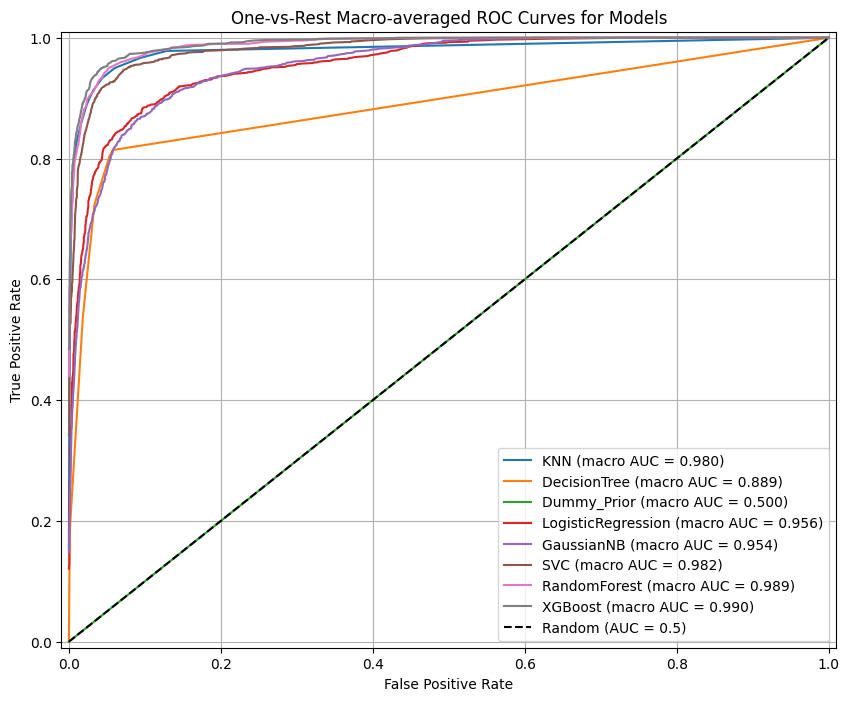

In [13]:
plt.figure(figsize=(10, 8))
for name, info in roc_results.items():
    plt.plot(info['all_fpr'], info['mean_tpr'], label=f"{name} (macro AUC = {info['macro_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest Macro-averaged ROC Curves for Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## B.3: ROC Interpretation

Highest macro-averaged AUC: XGBoost, RandomForest<br>
The macro-averaged ROC AUC results reinforce the trends seen in the baseline scores. XGBoost once again leads with a macro AUC of approximately 0.990, closely followed by RandomForest at 0.989, both demonstrating near-perfect class separability across the one-vs-rest ROC curves These high AUC values indicate that the models consistently rank true positive examples above false positives across all possible decision thresholds. SVC and KNN also perform strongly, with macro AUCs of 0.982 and 0.980 respectively, showing that they can effectively distinguish between classes even though they do not match the ensemble models’ overall precision.

Logistic Regression and Gaussian Naive Bayes achieve macro AUCs in the mid-0.95 range, suggesting good discriminative ability despite lower overall accuracy. These models are competent at ordering instances by confidence, but their simpler decision structures likely cause minor misrankings that lower their AUCs slightly. In contrast, the Decision Tree’s macro AUC of 0.889 reflects its instability: a single tree tends to overfit training data, producing overconfident predictions that generalize poorly to unseen samples. The Dummy Prior model, with an AUC of 0.5, represents random guessing, confirming that all trained models provide meaningful signal beyond chance. An ROC AUC below 0.5 indicates that the model is performing worse than random guessing, i.e., it systematically ranks negative examples as more likely to be positive than actual positive ones

Overall, the ROC results show that the ensemble approaches (XGBoost and RandomForest) are superior at separating the Landsat classes across thresholds, closely followed by SVC and KNN. These models exhibit strong global ranking capability, meaning they would perform well across different operating points or classification thresholds.

# Part C: Precision-Recall Curve (PRC) Analysis


## C.1: PRC Calculation

While ROC curves are informative, they can be overly optimistic for imbalanced datasets.  
The Precision-Recall Curve (PRC) focuses more directly on how well a model distinguishes positive samples when negatives dominate.

- Precision: Of all predicted positives, how many are correct?  
- Recall: Of all actual positives, how many are detected?

In this section, I'll compute macro-averaged Precision-Recall Curves and Average Precision (AP) scores for each model.

PRC  is a more suitable
metric than ROC when dealing with highly imbalanced classes because unlike ROC, PRC directly reflects how confident the model is about positive predictions, which is a better indicator of real-world performance when misclassifications are costly.


## C.2: Plotting PRC

In [14]:
pr_results = {}
for name, info in roc_results.items():
    y_score = info['y_score']
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test_binarized[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(Y_test_binarized[:, i], y_score[:, i])

    #I've computed macro-average precision-recall by interpolating recall points:
    all_recall = np.linspace(0, 1, 200)
    mean_precision = np.zeros_like(all_recall)
    for i in range(n_classes):
        r = recall[i]
        p = precision[i]
        idx = np.argsort(r)
        r_sorted = r[idx]
        p_sorted = p[idx]
        mean_precision += np.interp(all_recall, r_sorted, p_sorted, left=1.0)
    mean_precision /= n_classes
    macro_ap = np.mean(list(average_precision.values()))
    pr_results[name] = {
        'precision': precision,
        'recall': recall,
        'average_precision': average_precision,
        'all_recall': all_recall,
        'mean_precision': mean_precision,
        'macro_ap': macro_ap
    }

macro_aps = {name: info['macro_ap'] for name, info in pr_results.items()}
pd.Series(macro_aps).sort_values(ascending=False)

,0
XGBoost,0.950879
RandomForest,0.942316
KNN,0.921878
SVC,0.909475
LogisticRegression,0.822444
GaussianNB,0.802136
DecisionTree,0.708667
Dummy_Prior,0.166667


The plot below shows macro-averaged PR curves for all models.  
A model with higher precision at any recall level is preferred.

The Average Precision (AP) summarizes the entire curve into a single value — higher AP indicates better balance between precision and recall.

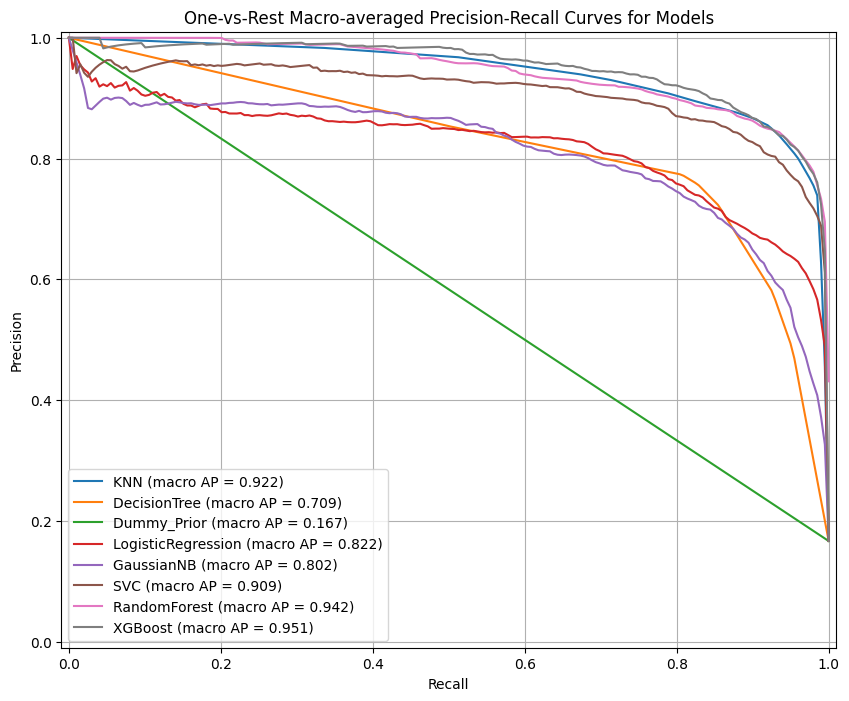

In [15]:
plt.figure(figsize=(10, 8))
for name, info in pr_results.items():
    plt.plot(info['all_recall'], info['mean_precision'], label=f"{name} (macro AP = {info['macro_ap']:.3f})")

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('One-vs-Rest Macro-averaged Precision-Recall Curves for Models')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

## C.3: PRC Interpretation

The Precision–Recall analysis provides a more nuanced view of model behavior, especially under potential class imbalance. Once again, XGBoost and RandomForest demonstrate the best performance, with macro-averaged Average Precision (AP) scores of 0.951 and 0.942 respectively. Their curves remain high and stable across nearly the entire recall range, indicating that these models maintain excellent precision even as recall increases. In practical terms, this means that when they identify a pixel as belonging to a particular class, they are correct most of the time, even when attempting to detect as many positive cases as possible.

KNN and SVC follow closely, with AP values of 0.922 and 0.909. These models maintain strong precision–recall tradeoffs, showing that their probability outputs are reliable and well-calibrated. Logistic Regression and GaussianNB perform moderately, achieving APs of around 0.82 and 0.80 respectively. While they can correctly rank predictions, they tend to lose precision as recall grows, likely because their simpler assumptions limit how well they capture nonlinear relationships. Decision Tree, with an AP of 0.709, struggles the most among the real models, suggesting that its confidence estimates are unstable and precision declines rapidly as more positives are retrieved. The Dummy Prior’s AP of 0.167 underscores its complete lack of predictive power.

Overall, the PR curves reaffirm that the ensemble models dominate in terms of both ranking quality and practical positive prediction reliability. High Average Precision combined with strong ROC AUC indicates that XGBoost and RandomForest not only separate classes well but also produce dependable high-confidence predictions, which is critical in imbalanced or high-stakes classification contexts.

# Part D: Final Recommendation

Bringing together the results from accuracy, weighted F1-score, ROC AUC, and Average Precision, XGBoost stands out as the most consistent and effective model for the Landsat Satellite dataset. It achieves the highest accuracy (0.917), the top weighted F1-score (0.916), the best macro ROC AUC (0.990), and the highest macro Average Precision (0.951). These results demonstrate that XGBoost offers excellent class separation, balanced precision and recall, and reliable probability calibration, making it the most robust overall choice. RandomForest follows very closely behind in every metric, showing that ensemble-based tree methods perform particularly well on this type of structured, moderately high-dimensional tabular data.

KNN and SVC also perform strongly and may be good alternatives when interpretability or specific computational constraints apply. However, they are less efficient on large datasets and may require more careful parameter tuning. Logistic Regression and GaussianNB, while serviceable, underperform compared to more flexible methods, indicating that linear or purely probabilistic models cannot fully capture the spectral–spatial complexity of the data. The Decision Tree’s lower performance suggests that ensemble averaging is necessary to stabilize tree-based predictions, while the Dummy Prior model confirms that the dataset’s structure contains enough signal for meaningful classification.

I'd recommend XGBoost as the best overall model for this task due to its combination of high accuracy, generalization capability, and balanced precision–recall behavior. In practical deployments, RandomForest could serve as an excellent fallback when computational simplicity or interpretability is desired. In summary, the ensemble models not only perform best quantitatively but also provide the most reliable and generalizable solutions for the Landsat Satellite classification problem.

## Brownie Points:


Here, I've created a deliberately bad model by training a linear regression model on shuffled labels. As we will see, the AUC of this model will be lesser than 0.5.

In [16]:
from sklearn.base import clone
bad_lr = clone(models['LogisticRegression'])
np.random.seed(0)
y_train_shuffled = np.random.permutation(y_train)
bad_lr.fit(X_train_scaled, y_train_shuffled)
trained_models['LogisticRegression_shuffled'] = bad_lr
try:
    y_score_bad = bad_lr.predict_proba(X_test_scaled)
except Exception:
    df = bad_lr.decision_function(X_test_scaled)
    if df.ndim == 1:
        df = np.vstack([-df, df]).T
    exp = np.exp(df - np.max(df, axis=1, keepdims=True))
    y_score_bad = exp / np.sum(exp, axis=1, keepdims=True)

fpr_bad = {}
tpr_bad = {}
roc_auc_bad = {}
for i in range(n_classes):
    fpr_bad[i], tpr_bad[i], _ = roc_curve(Y_test_binarized[:, i], y_score_bad[:, i])
    roc_auc_bad[i] = auc(fpr_bad[i], tpr_bad[i])
all_fpr_bad = np.unique(np.concatenate([fpr_bad[i] for i in range(n_classes)]))
mean_tpr_bad = np.zeros_like(all_fpr_bad)
for i in range(n_classes):
    mean_tpr_bad += np.interp(all_fpr_bad, fpr_bad[i], tpr_bad[i])
mean_tpr_bad /= n_classes
macro_auc_bad = auc(all_fpr_bad, mean_tpr_bad)
print('Shuffled-Logistic macro AUC:', macro_auc_bad)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Shuffled-Logistic macro AUC: 0.476615694873741
